# Choice Set space for Neural Data

 The idea is to create a choice set that: samples the same SV difference (+ - some variation) with different trials.
 - 5 different SV deltas, including 0.   

In [1]:
#Import the relevant libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 999
#pd.options.display.max_columns = 999

# 1. Input: 
- Patient's RAW data

- Parameters from the utility model

In [2]:
path= 'Z:\datasets\ICR' #Specify where the data is stored in the FileShare. This is for my Laptop

#Path to the data files
#path = '/Volumes/UCDN/datasets/ICR' #MAC path to the File share
patient_code = 'NIH116_C' #Specify the patient's code
patient_split_dir = os.path.join(path,'split') 
patient_trials = os.path.join(patient_split_dir,'{}/crdm/{}_crdm.csv').format(patient_code,patient_code) #This is the psychopy output CSV

#Path to the utility model data
utility_dir = os.path.join(path,'utility')
utility_analysis = os.path.join(utility_dir,'split_CRDM_analysis_1000runs.csv')
parameters = pd.read_csv(utility_analysis)

print('loading fn: {}'.format(patient_trials))
print('loading fn: {}'.format(utility_analysis))

loading fn: Z:\datasets\ICR\split\NIH116_C/crdm/NIH116_C_crdm.csv
loading fn: Z:\datasets\ICR\utility\split_CRDM_analysis_1000runs.csv


In [3]:
#Declare the variables we are going to be using

trials = pd.read_csv(patient_trials)
p_options = trials['crdm_lott_p'].unique()/100
p_options = p_options[~np.isnan(p_options)]  # Remove nan values ~is a logical NOT operator
p_options = p_options.tolist()  # Do we want p_options to be an array or a list? Ask Ricardo 
p_options = sorted(p_options, reverse=True)
amb_options = [0.24, 0.5, 0.74]

#Declare the variables


# A= df['crdm_amb_lev'].values[0] #Ambiguity level
A_null = 0.0 # no ambiguity
Vmax = 50.0 #The maximum amount we can pay to participants
Vmin = -50.0 #The minimum amount we can take from participants
Vsafe_pos = 5.0 # The old safe option in positive trials
Vsafe_neg = -5.0 # The old safe option in negative trials

# used for populating trials
empty_df = pd.DataFrame([],columns=['category','p_reward', 'value_reward'])

p_options 


[0.75, 0.5, 0.38, 0.25, 0.13]

# 2. Running the model and plotting it

In [4]:

#From the CRDM_analysis CSV we pick our patient's parameters
filtered_parameters = parameters[parameters['subject'] == patient_code]

# Create pos, comb, neg parameters and read them from the csv
alpha_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'alpha'].values[0]
#alpha_comb = filtered_parameters.loc[filtered_parameters['domain'] == 'combined', 'alpha'].values[0]
alpha_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'alpha'].values[0]


beta_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'beta'].values[0]
#beta_comb = filtered_parameters.loc[filtered_parameters['domain'] == 'combined', 'beta'].values[0]
beta_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'beta'].values[0]


print("alpha_pos:", alpha_pos)
#print("alpha_combined:", alpha_comb)
print("alpha_neg:", alpha_neg)

print("\nbeta_pos:", beta_pos)
#print("beta_combined:", beta_comb)
print("beta_neg:", beta_neg)



alpha_pos: 1.650490508048315
alpha_neg: 0.4419771944688798

beta_pos: 1.6203830287383036
beta_neg: -0.613138386690961


In [5]:
def plot_sv(alpha, beta, trials = 'gains'): #Define a function to plot SV given participant's input
    A = 0 
    p_options = [1.0, 0.87, 0.75, 0.62, 0.5, 0.38, 0.25, 0.13] #We want a line for every probability level. The 1.0 is the classic (non risky) utility function
    
    v = np.linspace(0, 50, 100) # The x axis goes from 0 to 50 an takes 100 points (just to make the figure smooth
    if trials == 'losses':
        v = np.linspace(0, -50, 100)
    plt.figure(figsize=(10, 6)) #Create a plot figure
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    for p in p_options: #Iterate through each probability level
        sv = (p - beta * A / 2)* Amp * abs(v)**alpha #Calculate the SV of every V from 0 to 50 for a given p
        if p == 1.0:  #Non risky 
            plt.plot(v, sv, label=f'p = {p}', linestyle='--', color='black') #If p=0, plot a black dashed line using V as X and SV as Y
        else:
            plt.plot(v, sv, label=f'p = {p}')
    fig_fn = os.path.join(utility_dir,patient_code,'crdm/{}_utility_model_{}_.eps'.format(patient_code, trials))
    print("Saving to: {}".format(fig_fn))

    
    plt.xlabel('Value of Reward')
    plt.ylabel('SV')
    plt.title("Patient's SV model for {}".format(trials))
    plt.legend()
    plt.grid(True)
    plt.savefig(fig_fn,format= 'eps')
    plt.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving to: Z:\datasets\ICR\utility\NIH116_C\crdm/NIH116_C_utility_model_gains_.eps


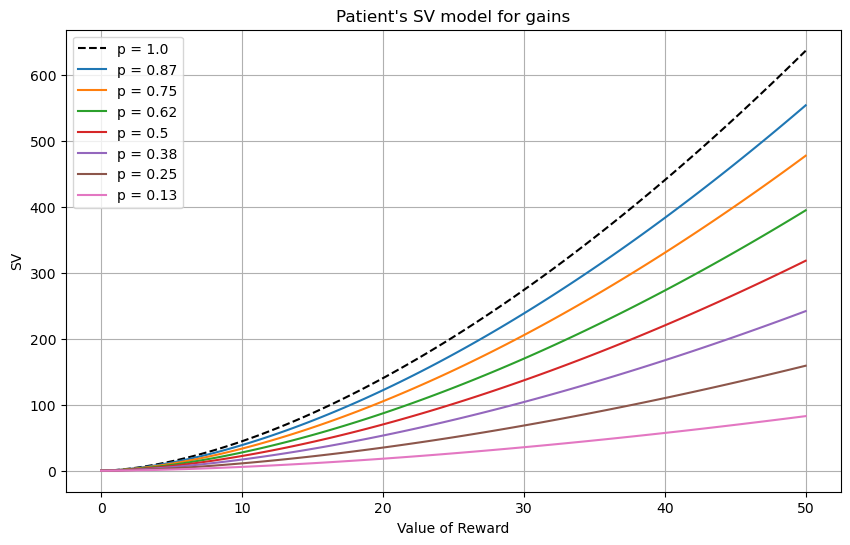

In [6]:
plot_sv(alpha_pos,beta_pos, trials = 'gains')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving to: Z:\datasets\ICR\utility\NIH116_C\crdm/NIH116_C_utility_model_losses_.eps


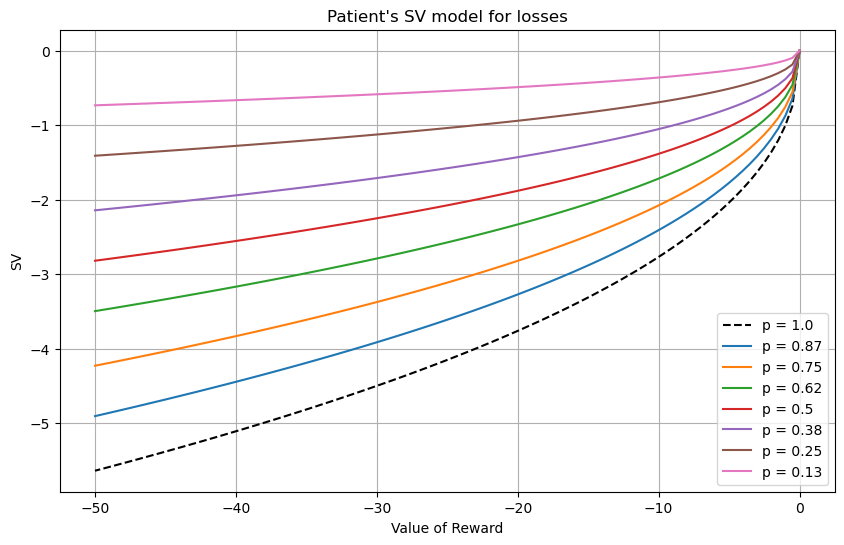

In [7]:
plot_sv(alpha_neg,beta_neg, trials = 'losses')

# 3. Creating the choice set

- 5 different SV deltas, including 0.
- Max SV delta
    - Winning or loosing $50 for each probability level
    - 


- Min SV delta: subjective equality trials. 

- 3 Intermediate trials. 


In [8]:
#Create the extreme positive gains and losses

def get_extreme(p_options,trials='gains'):
    extr = {} #Create an empty dict
    V = Vmax
    if trials=='losses': #If trials are losses, assign them -50
        V = Vmin
    for p in p_options: #Iterate through the probability levels
        extr[p] = V #Assign them the 50 dollars value
    return extr

extrpos = get_extreme(p_options)

extrneg = get_extreme(p_options,trials='losses')

#From the dictionaries, we create DataFrames to work with
def get_extr_df(extr_dict,trials='gains'):
    df_app = pd.DataFrame(extr_dict.items(), columns=['p_reward', 'value_reward'])
    Extr_df = pd.concat([empty_df, df_app], ignore_index=True)
    category = 'Extr_pos'
    if trials=='losses':
        category = 'Extr_neg'
    Extr_df['category'] = category
    Extr_df['ambiguity'] = A_null
    return Extr_df

def add_ambig_extr(df,amb_options,Vmax=50,prob_amb=0.50,trials='gains'):
    amb_dict = {prob_amb:amb_options}
    df_app = pd.DataFrame(amb_dict.items(), columns=['p_reward', 'ambiguity'])
    df_app = df_app.explode('ambiguity')
    df_app['category'] = df['category']
    df_app['value_reward'] = Vmax
    df = pd.concat([df,df_app],ignore_index=True)
    return df

# df_app = pd.DataFrame(centrials_neg.items(), columns=['p_reward', 'value_reward'])
# df_app = df_app.explode('value_reward')


#We define a function to calculate the SV of the trials given the 
#participant's alpha and beta

def append_SVreward(df,alpha,beta,trials='gains'):
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_reward'] = (df['p_reward'] - beta*df['ambiguity']/2)*Amp*(abs(df['value_reward']))**alpha
    return df

#We define a function to calculate the SV of the safe options of the trials given the 
#participant's alpha and beta

def append_Vsafe(df,alpha,beta,trials='gains'): 
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_New_Safe'] = 0.5*df['SV_reward']
    df['value_lott_SE'] = Amp*(abs(df['SV_New_Safe']) / (df['p_reward']-beta*df['ambiguity']/2)) ** (1 / alpha)
    df['value_safe'] = Amp*(abs(df['SV_New_Safe'])) ** (1 / alpha)
    return df

#Define the data frames
df_pos = get_extr_df(extrpos)
df_pos = add_ambig_extr(df_pos,amb_options)

df_neg = get_extr_df(extrneg,trials='losses')
df_neg = add_ambig_extr(df_neg,amb_options,Vmax=Vmin,trials='losses')


#Add the SV of reward and safe trials
df_pos = append_SVreward(df_pos,alpha_pos,beta_pos)
df_neg = append_SVreward(df_neg,alpha_neg,beta_neg,trials='losses')

df_pos = append_Vsafe(df_pos,alpha_pos,beta_pos)
df_neg = append_Vsafe(df_neg,alpha_neg,beta_neg,trials='losses')


In [9]:
# Safe option dataframe to use when merging multiple dataframes
df_safe_pos = df_pos[['p_reward','ambiguity','SV_New_Safe','value_lott_SE','value_safe']].copy()
df_safe_neg = df_neg[['p_reward','ambiguity','SV_New_Safe','value_lott_SE','value_safe']].copy()

#Define the trials of subjective equality

#For gains
df_SE_pos = df_pos[['category','p_reward','ambiguity','value_lott_SE', 'SV_New_Safe']].copy()
df_SE_pos['category'] = 'SE_pos'
df_SE_pos = df_SE_pos.rename(columns={'value_lott_SE':'value_reward'})
#df_SE_pos = append_SVreward(df_SE_pos,alpha_pos,beta_pos)
df_SE_pos['value_safe'] = df_safe_pos['value_safe']
df_SE_pos = df_SE_pos.rename(columns={'SV_New_Safe':'SV_reward'})
#df_SE_pos = df_SE_pos.drop(columns=['SV_New_Safe','value_lott_SE'])

#For losses
df_SE_neg = df_neg[['category','p_reward','ambiguity','value_lott_SE', 'SV_New_Safe']].copy()
df_SE_neg['category'] = 'SE_neg'
df_SE_neg = df_SE_neg.rename(columns={'value_lott_SE':'value_reward'})
#df_SE_pos = append_SVreward(df_SE_pos,alpha_pos,beta_pos)
df_SE_neg['value_safe'] = df_safe_neg['value_safe']
df_SE_neg = df_SE_neg.rename(columns={'SV_New_Safe':'SV_reward'})
#df_SE_pos = df_SE_pos.drop(columns=['SV_New_Safe','value_lott_SE'])

#Centered around SE

#For gains
df_cent_pos= df_SE_pos.copy()

df_cent_pos['category'] = 'Cent_SE_pos'
#df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)
#df_cent_pos = pd.merge(df_cent_pos,df_safe_pos,on='p_reward')

#New dfs
df_adjusted_pos = df_cent_pos.copy()
df_adjusted_pos['value_reward'] = df_adjusted_pos['value_reward'] +2.0

df_adjusted_neg = df_cent_pos.copy()
df_adjusted_neg['value_reward'] = df_adjusted_neg['value_reward'] - 2.0
df_cent_pos = pd.concat([df_cent_pos, df_adjusted_pos, df_adjusted_neg], ignore_index=True)

#Centered around SE DF
df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)

# Filter out rows with negative SV_reward values to avoid complex numbers in value of lottery
df_cent_pos = df_cent_pos[df_cent_pos['SV_reward'] >= 0]
df_cent_pos = df_cent_pos.round(2)
df_cent_pos

,category,p_reward,ambiguity,value_reward,SV_reward,value_safe
0,Cent_SE_pos,0.75,0.0,32.853512,238.871938,27.598397
1,Cent_SE_pos,0.50,0.0,32.853512,159.247959,21.587065
2,Cent_SE_pos,0.38,0.0,32.853512,121.028449,18.280197
3,Cent_SE_pos,0.25,0.0,32.853512,79.623979,14.184218
4,Cent_SE_pos,0.13,0.0,32.853512,41.404469,9.544152
5,Cent_SE_pos,0.50,0.24,32.853512,97.317713,16.017941
6,Cent_SE_pos,0.50,0.5,32.853512,30.226614,7.887495
8,Cent_SE_pos,0.75,0.0,34.853512,263.34468,27.598397
9,Cent_SE_pos,0.50,0.0,34.853512,175.56312,21.587065
10,Cent_SE_pos,0.38,0.0,34.853512,133.427971,18.280197


In [10]:

#For losses
df_cent_neg= df_SE_neg.copy()

df_cent_neg['category'] = 'Cent_SE_neg'
#df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)
#df_cent_pos = pd.merge(df_cent_pos,df_safe_pos,on='p_reward')

#New dfs
df1_adjusted_pos = df_cent_neg.copy()
df1_adjusted_pos['value_reward'] = df1_adjusted_pos['value_reward'] +2.0

df1_adjusted_neg = df_cent_neg.copy()
df1_adjusted_neg['value_reward'] = df1_adjusted_neg['value_reward'] - 2.0
df_cent_neg = pd.concat([df_cent_neg, df1_adjusted_pos, df1_adjusted_neg], ignore_index=True)

#Centered around SE DF
df_cent_neg = append_SVreward(df_cent_neg,alpha_neg,beta_neg,trials='losses')


In [11]:
df_pos = df_pos.sort_values('SV_reward', ascending=False).reset_index(drop=True)
df_neg = df_neg.sort_values('SV_reward', ascending=True).reset_index(drop=True)

In [12]:
df_pos

,category,p_reward,value_reward,ambiguity,SV_reward,SV_New_Safe,value_lott_SE,value_safe
0,Extr_pos,0.75,50.0,0.0,477.743876,238.871938,32.853512,27.598397
1,Extr_pos,0.50,50.0,0.0,318.495918,159.247959,32.853512,21.587065
2,Extr_pos,0.38,50.0,0.0,242.056897,121.028449,32.853512,18.280197
3,Extr_pos,0.50,50.0,0.24,194.635426,97.317713,32.853512,16.017941
4,Extr_pos,0.25,50.0,0.0,159.247959,79.623979,32.853512,14.184218
5,Extr_pos,0.13,50.0,0.0,82.808939,41.404469,32.853512,9.544152
6,Extr_pos,0.50,50.0,0.5,60.453228,30.226614,32.853512,7.887495
7,Extr_pos,0.50,50.0,0.74,-63.407263,-31.703632,(-10.727761932541132+31.052671032662435j),8.118815


In [13]:
df_neg

,category,p_reward,value_reward,ambiguity,SV_reward,SV_New_Safe,value_lott_SE,value_safe
0,Extr_neg,0.75,-50.0,0.0,-4.226368,-2.113184,-10.420091,-5.434882
1,Extr_neg,0.50,-50.0,0.74,-4.095977,-2.047988,-10.420091,-5.062875
2,Extr_neg,0.50,-50.0,0.5,-3.681361,-1.840681,-10.420091,-3.976762
3,Extr_neg,0.50,-50.0,0.24,-3.232194,-1.616097,-10.420091,-2.96258
4,Extr_neg,0.50,-50.0,0.0,-2.817578,-1.408789,-10.420091,-2.171566
5,Extr_neg,0.38,-50.0,0.0,-2.14136,-1.07068,-10.420091,-1.167096
6,Extr_neg,0.25,-50.0,0.0,-1.408789,-0.704395,-10.420091,-0.452558
7,Extr_neg,0.13,-50.0,0.0,-0.73257,-0.366285,-10.420091,-0.103066


In [14]:
#Selecting ourg SVdiff sampling. We are doing this by ojo of which SVdiff allows more sampling.
#We need to create a more systematic method. 

#For Gains
df_pos = df_pos.sort_values('SV_reward', ascending=False).reset_index(drop=True)
# fourth ranked SV_reward
index = 3
# SV_reward
col = 4
SV_max_pos = df_pos.iloc[index,col]
_SV_safe = df_pos.iloc[index,col+1]
# sampling here
_delta_SV = SV_max_pos - _SV_safe
# second sampling
_delta_SV2 = 0.5 * _delta_SV


#For Losses

# fourth ranked SV_reward
neg_index = 3
# SV_reward
neg_col = 4
SV_min_neg = df_neg.iloc[neg_index,neg_col]
neg_SV_safe = df_neg.iloc[neg_index,neg_col+1]
# sampling here
neg_delta_SV = SV_min_neg - neg_SV_safe
# second sampling
neg_delta_SV2 = 0.5 * neg_delta_SV



In [15]:
#Creating the Neg target SVdeltas and SV_rewards
neg_df1 = df_neg[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
neg_df1['category'] = 'MaxSVdelta_Loss'
neg_df1['deltaSV'] = neg_delta_SV
neg_df1['SV_reward'] = neg_df1['deltaSV'] + neg_df1['SV_New_Safe']
#new_df1

neg_df2 = df_neg[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
neg_df2['category'] = 'Neg_Half_maxSV_delta'
neg_df2['deltaSV'] = neg_delta_SV2
neg_df2['SV_reward'] = neg_df2['deltaSV'] + neg_df2['SV_New_Safe']
neg_df2

#neg_df3 = pd.concat([neg_df1,neg_df2], ignore_index=True)

neg_df3 = df_neg[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
neg_df3['category'] = 'MinSVdelta'
neg_df3['deltaSV'] = -1.0*neg_delta_SV
neg_df3['SV_reward'] = neg_df3['deltaSV'] + neg_df3['SV_New_Safe']


neg_df4 = df_neg[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
neg_df4['category'] = 'Neg_Half_minSV_delta'
neg_df4['deltaSV'] = -1.0*neg_delta_SV2
neg_df4['SV_reward'] = neg_df4['deltaSV'] + neg_df4['SV_New_Safe']
#new_df4 = pd.concat([min_df1,min_df2], ignore_index=True)
neg_df = pd.concat([neg_df1,neg_df2,neg_df3,neg_df4], ignore_index=True) 


In [16]:

#Creating the Neg target SVdeltas and SV_rewards
new_df1 = df_pos[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
new_df1['category'] = 'MaxSVdelta'
new_df1['deltaSV'] = _delta_SV
new_df1['SV_reward'] = new_df1['deltaSV'] + new_df1['SV_New_Safe']
#new_df1

new_df2 = df_pos[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
new_df2['category'] = 'half_maxSV_delta'
new_df2['deltaSV'] = _delta_SV2
new_df2['SV_reward'] = new_df2['deltaSV'] + new_df2['SV_New_Safe']
new_df3 = pd.concat([new_df1,new_df2], ignore_index=True)

min_df1 = df_pos[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
min_df1['category'] = 'MinSVdelta'
min_df1['deltaSV'] = -1.0*_delta_SV
min_df1['SV_reward'] = min_df1['deltaSV'] + min_df1['SV_New_Safe']


min_df2 = df_pos[['category','p_reward', 'ambiguity', 'value_safe', 'SV_New_Safe']].copy()
min_df2['category'] = 'Half_minSV_delta'
min_df2['deltaSV'] = -1.0*_delta_SV2
min_df2['SV_reward'] = min_df2['deltaSV'] + min_df2['SV_New_Safe']
new_df4 = pd.concat([min_df1,min_df2], ignore_index=True)
new_df5 = pd.concat([new_df3, new_df4], ignore_index=True) 

In [17]:
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]
#alpha_comb = 0.9555108189143096
#beta_comb = 0.617126793788233
def calculate_value_reward(df, alpha, beta):
    new_rows = []
    for index,row in df.iterrows(): #loop to go through each row in the input DataFrame (df)
                                # and extract the relevant values to calculate value_reward
        SV = row['SV_reward']  #The SV of the given row
        value_safe = row['value_safe'] #To keep value_safe constant
        p= row['p_reward']
        #value_safe = 5.0
        A = row['ambiguity'] 
        if A!= 0:
            p=0.50
        #if A == 0.74:
         #   continue
        if SV<0.0: 
            continue    
        value_reward = (SV/(p-beta*A/2))**(1/alpha) #Having issues with this beta. 
        if (value_reward <100) and (value_reward>=0.0):
            new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) 
            
            #All the calculated values are used to create a new dictionary for each combination.
            #The dictionaries are collected in a new rows list. 
            new_df = pd.DataFrame(new_rows,columns=['category','p_reward','ambiguity', 'value_reward', 'SV_reward', 'value_safe']) #A new DF from the list
            new_df = new_df.round(2) 
    return new_df

df_SVdeltas_gains = calculate_value_reward(new_df5, alpha_pos, beta_pos)
#df_pos1 = df_pos1.drop(columns=['SV_New_Safe'])
#df_pos1 = append_SVreward(df_pos1,alpha_comb,beta_comb)

df_SVdeltas_gains 

C:\Users\guardomayas2\AppData\Local\Temp\ipykernel_19972\2607997407.py:19: RuntimeWarning: invalid value encountered in scalar power
  value_reward = (SV/(p-beta*A/2))**(1/alpha) #Having issues with this beta.
C:\Users\guardomayas2\AppData\Local\Temp\ipykernel_19972\2607997407.py:19: RuntimeWarning: invalid value encountered in scalar power
  value_reward = (SV/(p-beta*A/2))**(1/alpha) #Having issues with this beta.


,category,p_reward,ambiguity,value_reward,SV_reward,value_safe
0,MaxSVdelta,0.75,0.00,40.41,336.19,27.60
1,MaxSVdelta,0.50,0.00,43.86,256.57,21.59
2,MaxSVdelta,0.38,0.00,46.97,218.35,18.28
3,MaxSVdelta,0.50,0.24,50.00,194.64,16.02
4,MaxSVdelta,0.25,0.00,53.30,176.94,14.18
5,MaxSVdelta,0.13,0.00,68.35,138.72,9.54
6,MaxSVdelta,0.50,0.50,78.60,127.54,7.89
7,half_maxSV_delta,0.75,0.00,36.76,287.53,27.60
8,half_maxSV_delta,0.50,0.00,38.61,207.91,21.59
9,half_maxSV_delta,0.38,0.00,40.32,169.69,18.28


In [18]:
''' still working in a single function
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]

def calculate_value_reward(df, alpha, beta, trials ='gains'):
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    new_rows = []
    for index,row in df.iterrows(): #loop to go through each row in the input DataFrame (df)
                                # and extract the relevant values to calculate value_reward
        SV = row['SV_reward']  #The SV of the given row
        value_safe = row['value_safe'] #To keep value_safe constant
        p= row['p_reward']
        #value_safe = 5.0
        A = row['ambiguity'] 
        if A!= 0:
            p=0.50    
        value_reward = (Amp*(abs(SV)/p - beta * A / 2))**(1/alpha)
        if trials == 'gains':
            if (value_reward <100) and (value_reward>=0.0):
                new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) 
        elif trials == 'losses':
            if (value_reward >-100) and (value_reward<=0.0):
                new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) 
            
        #All the calculated values are used to create a new dictionary for each combination.
        #The dictionaries are collected in a new rows list. 
        new_df = pd.DataFrame(new_rows,columns=['category','p_reward','ambiguity', 'value_reward', 'SV_reward', 'value_safe']) #A new DF from the list
        new_df = new_df.round(2) 
    return new_df

'''


" still working in a single function\np_options = [0.75, 0.5, 0.38, 0.25, 0.13]\n\ndef calculate_value_reward(df, alpha, beta, trials ='gains'):\n    Amp = 1.0\n    if trials == 'losses':\n        Amp = -1.0\n    new_rows = []\n    for index,row in df.iterrows(): #loop to go through each row in the input DataFrame (df)\n                                # and extract the relevant values to calculate value_reward\n        SV = row['SV_reward']  #The SV of the given row\n        value_safe = row['value_safe'] #To keep value_safe constant\n        p= row['p_reward']\n        #value_safe = 5.0\n        A = row['ambiguity'] \n        if A!= 0:\n            p=0.50    \n        value_reward = (Amp*(abs(SV)/p - beta * A / 2))**(1/alpha)\n        if trials == 'gains':\n            if (value_reward <100) and (value_reward>=0.0):\n                new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) \n  

In [19]:
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]
#alpha_neg: 0.5420177337405991
#beta_neg: -1.177300190736865
def calculate_value_reward_losses(df, alpha, beta):
    new_rows = []
    for index,row in df.iterrows(): #loop to go through each row in the input DataFrame (df)
                                # and extract the relevant values to calculate value_reward
        SV = row['SV_reward']  #The SV of the given row
        value_safe = row['value_safe'] #To keep value_safe constant
        p= row['p_reward']
        #value_safe = 5.0
        A = row['ambiguity'] 
        if A!= 0:
            p=0.50
        if SV>0.0: 
            continue    
        value_reward = -((abs(SV)/(p-beta*A/2))**(1/alpha))
        if (value_reward >-100) and (value_reward<=0.0):
            new_rows.append({'category': row['category'], 'SV_reward': SV, 'p_reward': p, 'ambiguity':A, 'value_safe': value_safe, 'value_reward': value_reward}) 
            
            #All the calculated values are used to create a new dictionary for each combination.
            #The dictionaries are collected in a new rows list. 
            new_df = pd.DataFrame(new_rows,columns=['category','p_reward','ambiguity', 'value_reward', 'SV_reward', 'value_safe']) #A new DF from the list
            new_df = new_df.round(2) 
    return new_df

df_SVdeltas_losses =  calculate_value_reward_losses(neg_df, alpha_neg, beta_neg)


# 4. Concat the DataFrames 

In [20]:
df_Trials_gains = pd.concat([df_SVdeltas_gains, df_cent_pos],ignore_index=True)
df_Trials_gains['SV_New_Safe'] = df_Trials_gains['value_safe']**alpha_pos
df_Trials_gains['deltaSV'] = df_Trials_gains['SV_reward'] - df_Trials_gains['SV_New_Safe']
#df_Trials_gains = df_Trials_gains.drop(columns=['value_lott_SE'])

#Convert selected columns to numeric values to be able to round
columns_to_convert = ['value_reward', 'value_safe', 'SV_reward', 'deltaSV']
df_Trials_gains[columns_to_convert] = df_Trials_gains[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df_Trials_gains = df_Trials_gains.round(2)
df_Trials_gains

,category,p_reward,ambiguity,value_reward,SV_reward,value_safe,SV_New_Safe,deltaSV
0,MaxSVdelta,0.75,0.0,40.41,336.19,27.60,238.894836,97.30
1,MaxSVdelta,0.50,0.0,43.86,256.57,21.59,159.283695,97.29
2,MaxSVdelta,0.38,0.0,46.97,218.35,18.28,121.026291,97.32
3,MaxSVdelta,0.50,0.24,50.00,194.64,16.02,97.338364,97.30
4,MaxSVdelta,0.25,0.0,53.30,176.94,14.18,79.584902,97.36
5,MaxSVdelta,0.13,0.0,68.35,138.72,9.54,41.374742,97.35
6,MaxSVdelta,0.50,0.5,78.60,127.54,7.89,30.242457,97.30
7,half_maxSV_delta,0.75,0.0,36.76,287.53,27.60,238.894836,48.64
8,half_maxSV_delta,0.50,0.0,38.61,207.91,21.59,159.283695,48.63
9,half_maxSV_delta,0.38,0.0,40.32,169.69,18.28,121.026291,48.66


In [21]:
df_Trials_losses = pd.concat([df_SVdeltas_losses, df_cent_neg],ignore_index=True)
df_Trials_losses['SV_New_Safe'] = -abs(df_Trials_losses['value_safe'])**alpha_neg
df_Trials_losses['deltaSV'] = df_Trials_losses['SV_reward'] - df_Trials_losses['SV_New_Safe']
#df_Trials_gains = df_Trials_gains.drop(columns=['value_lott_SE'])

#Convert selected columns to numeric values to be able to round
columns_to_convert = ['value_reward', 'value_safe', 'SV_reward']
df_Trials_losses[columns_to_convert] = df_Trials_losses[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df_Trials_losses = df_Trials_losses.round(2)
df_Trials_losses

,category,p_reward,ambiguity,value_reward,SV_reward,value_safe,SV_New_Safe,deltaSV
0,MaxSVdelta_Loss,0.75,0.0,-37.67,-3.73,-5.43,-2.112345,-1.617655
1,MaxSVdelta_Loss,0.50,0.74,-38.86,-3.66,-5.06,-2.047474,-1.612526
2,MaxSVdelta_Loss,0.50,0.5,-43.36,-3.46,-3.98,-1.841343,-1.618657
3,MaxSVdelta_Loss,0.50,0.24,-50.00,-3.23,-2.96,-1.615475,-1.614525
4,MaxSVdelta_Loss,0.50,0.0,-58.71,-3.02,-2.17,-1.40834,-1.61166
5,MaxSVdelta_Loss,0.38,0.0,-83.55,-2.69,-1.17,-1.071856,-1.618144
6,Neg_Half_maxSV_delta,0.75,0.0,-21.68,-2.92,-5.43,-2.112345,-0.807655
7,Neg_Half_maxSV_delta,0.50,0.74,-22.11,-2.86,-5.06,-2.047474,-0.812526
8,Neg_Half_maxSV_delta,0.50,0.5,-23.74,-2.65,-3.98,-1.841343,-0.808657
9,Neg_Half_maxSV_delta,0.50,0.24,-26.08,-2.42,-2.96,-1.615475,-0.804525


# 5. Making sure it works. 
A.k.a Sanity check 

In [22]:
from matplotlib.gridspec import GridSpec
import sys

def scatter_hist(x, y, ax, ax_histy,xlabel='',ylabel='',title=''): #This functions creates a scatter plot with histograms at its sides
	#ax.scatter(x, y)
	ax.set_xlabel(xlabel,fontsize=12) #Creates the subplots
	ax.set_ylabel(ylabel,fontsize=12)
	plt.suptitle(title,fontsize=16, ha='center')
	#ax_histx.hist(x,bins=20)
	ax_histy.hist(y, bins=20)
	ax_histy.set_xlabel('SV Difference')
	ax_histy.set_ylabel('Number of trials')
	plt.tight_layout()


def setup_fig_ax():  #Setting the axis

	fig = plt.figure(figsize=(8.5,8.5))
	gs = GridSpec(4, 3)

	ax = fig.add_subplot(gs[1:4, 0:3])
	ax_histy = fig.add_subplot(gs[0,0:3])
	#ax_histx = fig.add_subplot(gs[1:4, 3])
	#ax_histx.tick_params(axis="x", labelbottom=False)
	ax_histy.tick_params(axis="y")
 	
	#Adjust spacing around subplots
	#plt.subplots_adjust(top=1.4, bottom=0.15, left=0.15, right=0.9)
	
	return ax, ax_histy

def plot_scatter_hist(df,xvline=50,trials='gains'):

	# delta SV v.s value_reward
	x,y = df['value_reward'],df['deltaSV'] 
	ax,ax_histy = setup_fig_ax()

	scatter_hist(x,y,ax,ax_histy,  
		xlabel='Value of Reward',
		ylabel= 'SV difference',
		title= 'SV difference v.s value of Reward {}'.format(trials))

	colors = ['r','c','b','y','m','k','g']
	amb_line = ['--','-.',':']
	df = df.sort_values('value_reward')

	for i,p in enumerate(reversed(sorted(df['p_reward'].unique()))): #A scatter plot for each probability level
		df_p = df.loc[(df['p_reward']==p) & (df['ambiguity']==A_null)]
		x,y = df_p['value_reward'],df_p['deltaSV']
		ax.plot(x, y,'{}o-'.format(colors[i]),label='prob={0:0.2f}'.format(p)) #The plot conecting prob levels
		if p==0.50:
			for j,A in enumerate(reversed(sorted(df['ambiguity'].unique()))):
				if A==0:
					continue
				df_A = df.loc[(df['p_reward']==p) & (df['ambiguity']==A)]
				x,y = df_A['value_reward'],df_A['deltaSV']
				ax.plot(x, y,'{0}o{1}'.format(colors[i],amb_line[j]),label='amb={0:0.2f}'.format(A)) #The plot conecting prob levels
				
		

	# ax.plot([50],[],'r-')
	ax.axvline(x=xvline)
	# ax.plot([-50,-50],[-10,10],'r-')
	ax.axhline(y=0)
	# ax.plot([0,50],[0,0],'k--')
	ax.legend(loc="upper left")



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving to: Z:\datasets\ICR\utility\NIH116_C\crdm/NIH116_C_crdm_SVdelta_vs_valuereward_gains.eps


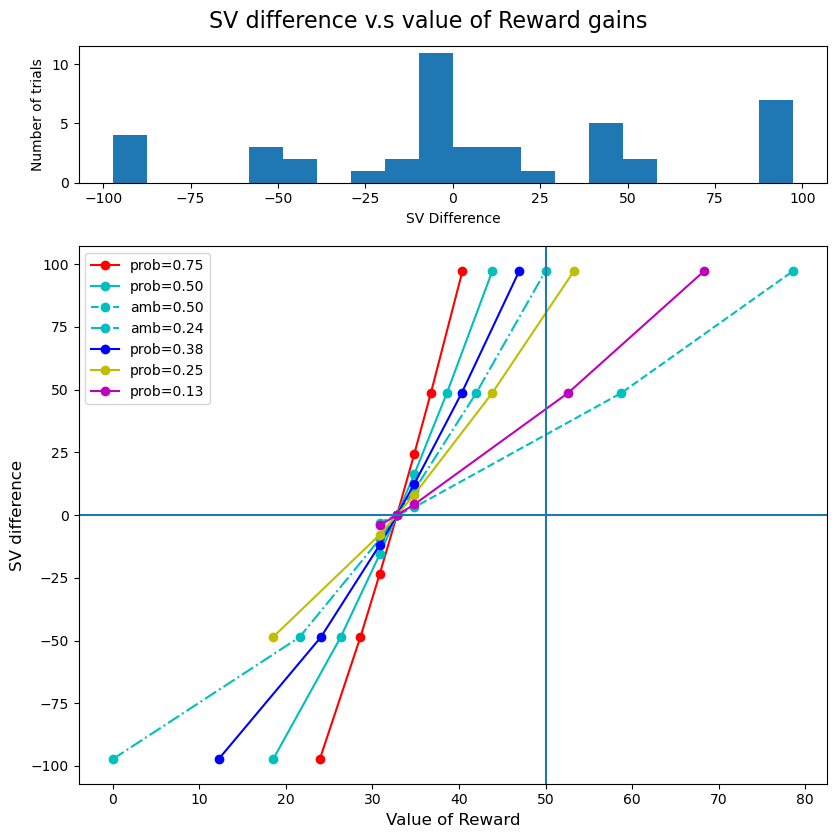

In [23]:
plot_scatter_hist(df_Trials_gains,xvline=50)
fig_fn = os.path.join(utility_dir,patient_code,'crdm/{}_crdm_SVdelta_vs_valuereward_gains.eps'.format(patient_code))
print("Saving to: {}".format(fig_fn))
plt.savefig(fig_fn, format='eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving to: Z:\datasets\ICR\utility\NIH116_C\crdm/NIH116_C_crdm_SVdelta_vs_valuereward_losses.eps


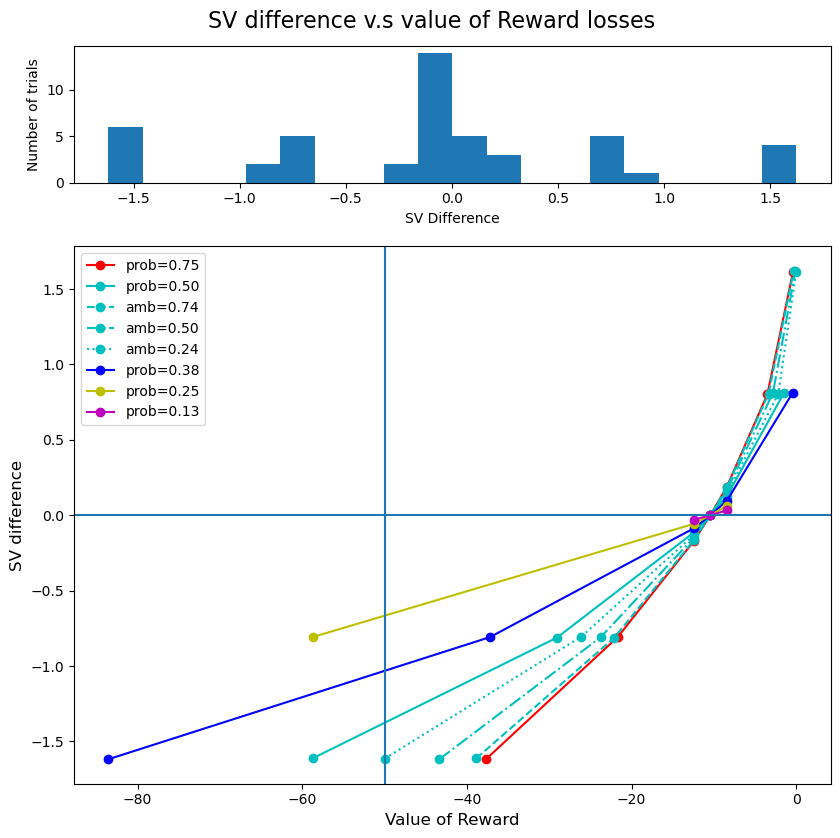

In [24]:
plot_scatter_hist(df_Trials_losses,xvline=-50,trials='losses')
fig_fn = os.path.join(utility_dir,patient_code,'crdm/{}_crdm_SVdelta_vs_valuereward_losses.eps'.format(patient_code))
print("Saving to: {}".format(fig_fn, format = 'eps'))
plt.savefig(fig_fn)
plt.show()

# 6. Output CSV


In [25]:
df_trials = pd.concat([df_Trials_gains,df_Trials_losses], ignore_index=True)
raw_trials = 'csv/{}_raw_trials.csv'.format(patient_code)
df_trials.to_csv(raw_trials,float_format='%.2f',index=False)
pd.read_csv(raw_trials)

,category,p_reward,ambiguity,value_reward,SV_reward,value_safe,SV_New_Safe,deltaSV
0,MaxSVdelta,0.75,0.00,40.41,336.19,27.60,238.894836,9.730000e+01
1,MaxSVdelta,0.50,0.00,43.86,256.57,21.59,159.283695,9.729000e+01
2,MaxSVdelta,0.38,0.00,46.97,218.35,18.28,121.026291,9.732000e+01
3,MaxSVdelta,0.50,0.24,50.00,194.64,16.02,97.338364,9.730000e+01
4,MaxSVdelta,0.25,0.00,53.30,176.94,14.18,79.584902,9.736000e+01
5,MaxSVdelta,0.13,0.00,68.35,138.72,9.54,41.374742,9.735000e+01
6,MaxSVdelta,0.50,0.50,78.60,127.54,7.89,30.242457,9.730000e+01
7,half_maxSV_delta,0.75,0.00,36.76,287.53,27.60,238.894836,4.864000e+01
8,half_maxSV_delta,0.50,0.00,38.61,207.91,21.59,159.283695,4.863000e+01
9,half_maxSV_delta,0.38,0.00,40.32,169.69,18.28,121.026291,4.866000e+01


In [26]:
#Let's reformat to match the psychopy CSV input
crdm_trials_gains = df_Trials_gains.copy()

crdm_trials_gains['category'] = 'gain'
crdm_trials_gains = crdm_trials_gains.sort_values('p_reward', ascending=True).reset_index(drop=True)
crdm_trials_gains = crdm_trials_gains.drop(columns=['SV_reward', 'SV_New_Safe','deltaSV'])
crdm_trials_gains['ambiguity'] = (crdm_trials_gains['ambiguity']*100).astype(int)
crdm_trials_gains['p_reward'] = (crdm_trials_gains['p_reward']*100).astype(int)
crdm_trials_gains = crdm_trials_gains.rename(columns={
    'value_safe':'crdm_sure_amt',
    'value_reward':'crdm_lott',
    'ambiguity': 'crdm_amb_lev',
    'p_reward':'crdm_lott_p', 
    'category':'crdm_domain'})
crdm_trials_gains['crdm_sure_p'] = 100
# Reordering columns
column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_gains = crdm_trials_gains[column_order]

# Sort the DataFrame first by 'crdm_lott_p' and then by 'crdm_amb_lev
crdm_trials_gains = crdm_trials_gains.sort_values(by=['crdm_lott_p', 'crdm_amb_lev'], ascending=[True,True])

# Separate rows with 'crdm_amb_lev' different from zero to the end
zero_ambiguity_rows = crdm_trials_gains[crdm_trials_gains['crdm_amb_lev'] == 0]
non_zero_ambiguity_rows = crdm_trials_gains[crdm_trials_gains['crdm_amb_lev'] != 0]

# Concatenate the DataFrames to put rows with 'crdm_amb_lev' different from zero at the end
crdm_trials_gains = pd.concat([zero_ambiguity_rows, non_zero_ambiguity_rows], ignore_index=True)
crdm_trials_gains


,crdm_sure_amt,crdm_sure_p,crdm_lott,crdm_lott_p,crdm_amb_lev,crdm_domain
0,9.54,100,52.61,13,0,gain
1,9.54,100,30.85,13,0,gain
2,9.54,100,68.35,13,0,gain
3,9.54,100,32.85,13,0,gain
4,9.54,100,34.85,13,0,gain
5,14.18,100,18.54,25,0,gain
6,14.18,100,30.85,25,0,gain
7,14.18,100,53.30,25,0,gain
8,14.18,100,34.85,25,0,gain
9,14.18,100,43.86,25,0,gain


In [27]:
# Randomly assign values to crdm_lott_top or crdm_lott_bot
# randomly select whether each value should go to the crdm_lott_top or crdm_lott_bot column
random_assignments = np.random.choice(['crdm_lott_top', 'crdm_lott_bot'], size=len(crdm_trials_gains))

# np.where to conditionally assign values from the crdm_lott column to the appropriate 
# columns based on the random selections
crdm_trials_gains['crdm_lott_top'] = np.where(random_assignments == 'crdm_lott_top', crdm_trials_gains['crdm_lott'], 0)
crdm_trials_gains['crdm_lott_bot'] = np.where(random_assignments == 'crdm_lott_bot', crdm_trials_gains['crdm_lott'], 0)

# Display the modified DataFrame
crdm_trials_gains


,crdm_sure_amt,crdm_sure_p,crdm_lott,crdm_lott_p,crdm_amb_lev,crdm_domain,crdm_lott_top,crdm_lott_bot
0,9.54,100,52.61,13,0,gain,0.00,52.61
1,9.54,100,30.85,13,0,gain,0.00,30.85
2,9.54,100,68.35,13,0,gain,68.35,0.00
3,9.54,100,32.85,13,0,gain,0.00,32.85
4,9.54,100,34.85,13,0,gain,0.00,34.85
5,14.18,100,18.54,25,0,gain,0.00,18.54
6,14.18,100,30.85,25,0,gain,30.85,0.00
7,14.18,100,53.30,25,0,gain,53.30,0.00
8,14.18,100,34.85,25,0,gain,34.85,0.00
9,14.18,100,43.86,25,0,gain,0.00,43.86


In [28]:

column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_gain = crdm_trials_gains[column_order]
crdm_trials_gain

,crdm_sure_amt,crdm_sure_p,crdm_lott_top,crdm_lott_bot,crdm_lott_p,crdm_amb_lev,crdm_domain
0,9.54,100,0.00,52.61,13,0,gain
1,9.54,100,0.00,30.85,13,0,gain
2,9.54,100,68.35,0.00,13,0,gain
3,9.54,100,0.00,32.85,13,0,gain
4,9.54,100,0.00,34.85,13,0,gain
5,14.18,100,0.00,18.54,25,0,gain
6,14.18,100,30.85,0.00,25,0,gain
7,14.18,100,53.30,0.00,25,0,gain
8,14.18,100,34.85,0.00,25,0,gain
9,14.18,100,0.00,43.86,25,0,gain


In [29]:
#Let's reformat to match the psychopy CSV input
crdm_trials_losses = df_Trials_losses.copy()
crdm_trials_losses = crdm_trials_losses.sort_values('p_reward', ascending=True).reset_index(drop=True)
crdm_trials_losses['category'] = 'loss'
crdm_trials_losses = crdm_trials_losses.drop(columns=['SV_reward', 'SV_New_Safe','deltaSV'])
crdm_trials_losses['ambiguity'] = (crdm_trials_losses['ambiguity']*100).astype(int)
crdm_trials_losses['p_reward'] = (crdm_trials_losses['p_reward']*100).astype(int)
crdm_trials_losses = crdm_trials_losses.rename(columns={
    'value_safe':'crdm_sure_amt',
    'value_reward':'crdm_lott',
    'ambiguity': 'crdm_amb_lev',
    'p_reward':'crdm_lott_p', 
    'category':'crdm_domain'})
crdm_trials_losses['crdm_sure_p'] = 100
# Reordering columns
column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_losses = crdm_trials_losses[column_order]
#crdm_trials_losses =crdm_trials_losses.sort_values(by=['crdm_lott_p', 'crdm_amb_lev'], ascending=True).reset_index(drop=True)

# Sort the DataFrame first by 'crdm_lott_p' and then by 'crdm_amb_lev
crdm_trials_losses = crdm_trials_losses.sort_values(by=['crdm_lott_p', 'crdm_amb_lev'], ascending=[True,True])

# Separate rows with 'crdm_amb_lev' different from zero to the end
zero_ambiguity_rows_loss = crdm_trials_losses[crdm_trials_losses['crdm_amb_lev'] == 0]
non_zero_ambiguity_rows_loss = crdm_trials_losses[crdm_trials_losses['crdm_amb_lev'] != 0]

# Concatenate the DataFrames to put rows with 'crdm_amb_lev' different from zero at the end
crdm_trials_losses = pd.concat([zero_ambiguity_rows_loss, non_zero_ambiguity_rows_loss], ignore_index=True)




In [30]:
# Randomly assign values to crdm_lott_top or crdm_lott_bot
# randomly select whether each value should go to the crdm_lott_top or crdm_lott_bot column
random_assignments = np.random.choice(['crdm_lott_top', 'crdm_lott_bot'], size=len(crdm_trials_losses))

# np.where to conditionally assign values from the crdm_lott column to the appropriate 
# columns based on the random selections
crdm_trials_losses['crdm_lott_top'] = np.where(random_assignments == 'crdm_lott_top', crdm_trials_losses['crdm_lott'], 0)
crdm_trials_losses['crdm_lott_bot'] = np.where(random_assignments == 'crdm_lott_bot', crdm_trials_losses['crdm_lott'], 0)

# Display the modified DataFrame
crdm_trials_losses

,crdm_sure_amt,crdm_sure_p,crdm_lott,crdm_lott_p,crdm_amb_lev,crdm_domain,crdm_lott_top,crdm_lott_bot
0,-0.10,100,-8.42,13,0,loss,0.00,-8.42
1,-0.10,100,-10.42,13,0,loss,0.00,-10.42
2,-0.10,100,-12.42,13,0,loss,-12.42,0.00
3,-0.45,100,-8.42,25,0,loss,-8.42,0.00
4,-0.45,100,-12.42,25,0,loss,-12.42,0.00
5,-0.45,100,-10.42,25,0,loss,-10.42,0.00
6,-0.45,100,-58.71,25,0,loss,-58.71,0.00
7,-1.17,100,-0.43,38,0,loss,-0.43,0.00
8,-1.17,100,-10.42,38,0,loss,0.00,-10.42
9,-1.17,100,-83.55,38,0,loss,-83.55,0.00


In [31]:
column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain'
]
crdm_trials_loss = crdm_trials_losses[column_order]


In [32]:
crdm_trials = pd.concat([crdm_trials_gain,crdm_trials_loss],ignore_index=True)
#crdm_trials['crdm_win_side'] = 'bottom'
#crdm_trials.loc[crdm_trials['crdm_lott_top'] !=0.00, 'crdm_win_side'] = 'top'  


Creating the crdm_win_side column

In [33]:
#We define the list of image filenames. 
#For now, it is hardcoded. I need to work in soft coding it from 
#the participant's output csv 'crdm_img' column. 
 
   #risk images filenames
rimages = [ 'risk_blue_75.bmp','risk_blue_50.bmp', 'risk_blue_38.bmp','risk_blue_25.bmp', 'risk_blue_13.bmp',
           'risk_red_75.bmp','risk_red_50.bmp',  'risk_red_38.bmp', 'risk_red_25.bmp', 'risk_red_13.bmp']
    #Ambiguity images filenames
aimages = ['ambig_24.bmp', 'ambig_50.bmp','ambig_74.bmp']


p_options_100 = [int(p * 100) for p in p_options] #We define the probabilities as integers. This is to be consistent with the output csv format
risk_images = {} #Empty dict to store the results. 

for p in p_options_100: #Iterate through each probability
    #For each probability value, we start with an empty list named 
    # matching_images to hold the filenames that match the current probability 
    matching_images = [img for img in rimages if isinstance(img, str) and f"_{p}" in img]
    #For each image filename, we check if it's a string 
    # and if the formatted probability (like "_75") is present in the filename.
    #If both conditions are true, the image filename is added to the list. 
    risk_images[p] = matching_images #After iterating through the file names,we assign the list
    #to the risk_images dictionary using p as a key. 



amb_options = [0.24, 0.5, 0.74]
amb_options_100 = [int(a * 100) for a in amb_options]
amb_images = {}

for a in amb_options_100:
    matching_images = [img for img in aimages if isinstance(img, str) and f"ambig_{a}" in img]
    amb_images[a] = matching_images



In [34]:
def determine_win_side(row): #Function the determine the wining side of the lottery. 
    if row['crdm_lott_top'] != 0.00:
        return 'top'
    else:
        return 'bottom'
    
# Apply the function to create the 'crdm_win_side' column
crdm_trials['crdm_win_side'] = crdm_trials.apply(determine_win_side, axis=1)
#crdm_trials

#Function to created crdm_image
def determine_risk_image_file(row):
    for p, f in risk_images.items():
        if row['crdm_lott_p'] == p and row['crdm_win_side'] == 'top':
            return  f[1] #using the 2nd item in the dictionary for red images
        elif row['crdm_lott_p'] == p and row['crdm_win_side'] == 'bottom':
            return f[0] #Using the first item of the dict as blue
crdm_trials['crdm_img'] = crdm_trials.apply(determine_risk_image_file,axis =1)

column_order = [
    'crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_domain', 'crdm_img', 'crdm_win_side']
crdm_trials = crdm_trials[column_order]
crdm_trials

,crdm_sure_amt,crdm_sure_p,crdm_lott_top,crdm_lott_bot,crdm_lott_p,crdm_amb_lev,crdm_domain,crdm_img,crdm_win_side
0,9.54,100,0.00,52.61,13,0,gain,risk_blue_13.bmp,bottom
1,9.54,100,0.00,30.85,13,0,gain,risk_blue_13.bmp,bottom
2,9.54,100,68.35,0.00,13,0,gain,risk_red_13.bmp,top
3,9.54,100,0.00,32.85,13,0,gain,risk_blue_13.bmp,bottom
4,9.54,100,0.00,34.85,13,0,gain,risk_blue_13.bmp,bottom
5,14.18,100,0.00,18.54,25,0,gain,risk_blue_25.bmp,bottom
6,14.18,100,30.85,0.00,25,0,gain,risk_red_25.bmp,top
7,14.18,100,53.30,0.00,25,0,gain,risk_red_25.bmp,top
8,14.18,100,34.85,0.00,25,0,gain,risk_red_25.bmp,top
9,14.18,100,0.00,43.86,25,0,gain,risk_blue_25.bmp,bottom


In [35]:
crdm_trials_csv = 'csv/{}_adaptive_trials.csv'.format(patient_code)
crdm_trials.to_csv(crdm_trials_csv,float_format='%.2f',index=False)
#pd.read_csv(crdm_trials_csv)

https://i.pinimg.com/736x/f3/6c/11/f36c119a1229c67741fca443fc97de6d.jpg